# Abnormal returns classifier

# Import packages and Datasets

In [1]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import keras
from keras import models
from keras import layers
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional

import gc #Garbage Collector interface
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import sklearn.metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score #The F-Measure is a popular metric for imbalanced classification.
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

from sklearn.utils import class_weight

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [2]:
# import Google Drive 套件
from google.colab import drive

# 將自己的雲端硬碟掛載上去
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# 透過 gdrive/My Drive/... 來存取檔案
data_df = pd.read_excel('gdrive/My Drive/金融科技Final_project/2019+2020年新聞資訊事件_股價報酬_528.xlsx')

In [4]:
data_df.head()

,個股代號,公司簡稱,事件日,TCRI(年/月),事件強度,收盤價,明日收盤價 / 昨日收盤價,明日收盤價 / 昨日收盤價 - 1,兩日報酬率(%),前5 ~ 245日平均兩日報酬率(%)，年平均正常報酬,前5 ~ 65日平均兩日報酬率(%)，季平均正常報酬,前5 ~ 25日平均兩日報酬率(%)，月平均正常報酬,前5 ~ 245日(年平均)兩日異常報酬,前5 ~ 65日(季平均)兩日異常報酬,前5 ~ 25日(月平均)兩日異常報酬,大事件類別,小事件類別,事件內容,Unnamed: 18,content_tokenized
0,1218,泰山,20190101,6(2018/09),0,19.00,0.972973,-0.027027,-2.702703,0.072009,-0.126391,0.911512,-2.774712,-2.576311,-3.614215,M_經營層,MT06_高管異動,發言人林俐婉內部調動，由江巍峰接任。。,19.0,發言人 林俐婉 內部 調動 由 江巍峰 接任
1,1503,士電,20190101,4(2018/09),0,40.95,0.997540,-0.002460,-0.246002,-0.000782,-0.459071,-0.042079,-0.245220,0.213068,-0.203923,M_經營層,MT06_高管異動,內部稽核主管林志強內部調動，由莊文清接任。。,22.0,內部 稽核 主管 林志強 內部 調動 由 莊文清 接任
2,1504,東元,20190101,4(2018/09),0,17.45,0.994302,-0.005698,-0.569801,-0.373847,-0.699126,0.436007,-0.195954,0.129325,-1.005807,M_經營層,MT06_高管異動,會計主管藍俊雄內部調動，由林鴻名接任。。,20.0,會計 主管 藍俊雄 內部 調動 由 林鴻名 接任
3,1709,和益,20190101,5(2018/09),0,14.80,1.003367,0.003367,0.336700,-0.097105,-0.364538,-0.160870,0.433805,0.701238,0.497570,M_經營層,MT06_高管異動,內部稽核主管游本詮內部調動，由曾筱茜接任。。,22.0,內部 稽核 主管 游本詮 內部 調動 由 曾筱茜 接任
4,1721,三晃,20190101,7(2018/09),0,10.05,1.000000,0.000000,0.000000,-0.275157,-0.026065,0.557661,0.275157,0.026065,-0.557661,M_經營層,MT06_高管異動,財務經理洪廷宜內部調動，由王婷渝接任。。,20.0,財務 經理 洪廷宜 內部 調動 由 王婷渝 接任


## Define "preprocess_text" functions

In [0]:
def preprocess_text(corpus, MAX_NUM_WORDS = 10000, MAX_SEQUENCE_LENGTH = 1000):
  tokenizer = keras .preprocessing.text.Tokenizer(num_words=MAX_NUM_WORDS)
  tokenizer.fit_on_texts(corpus)
  output = tokenizer.texts_to_sequences(corpus)
  output = keras .preprocessing .sequence .pad_sequences(output, maxlen=MAX_SEQUENCE_LENGTH)
  return output

## Data preprocessing

In [0]:
x = preprocess_text(corpus = data_df.content_tokenized, MAX_NUM_WORDS = 10000, MAX_SEQUENCE_LENGTH = 1305)

y = data_df["前5 ~ 25日(月平均)兩日異常報酬"]

In [7]:
def binary_encoding_returns(return_data):
  return_data[return_data>0] = 1
  return_data[return_data<=0] = 0
  return return_data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
y = binary_encoding_returns(y)

In [8]:
y.value_counts()

0.0    17896
1.0    17152
Name: 前5 ~ 25日(月平均)兩日異常報酬, dtype: int64

In [9]:
# baseline accuracy is about 0.51
17896/(17896+17152)

0.5106140150650537

## Split data into training dataset and testing dataset

In [0]:
# Split data to training data and testing data 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
X_par_train, X_val, y_par_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Model 1: 

3 hidden layers

In [0]:
model_1 = models.Sequential()
model_1.add(layers.Embedding(10000, 128))
# model_1.add(layers.LSTM(128,dropout=0.2,recurrent_dropout=0.2,return_sequences=True))
model_1.add(layers.LSTM(64,dropout=0,recurrent_dropout=0))
model_1.add(layers.Dense(32, activation='relu'))
model_1.add(layers.Dense(32, activation='relu'))
model_1.add(layers.Dense(1, activation='sigmoid'))

model_1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Iterate on your training data by calling the fit() method of your model
history = model_1.fit(X_par_train, y_par_train,
                    epochs=10,
                    batch_size=500,
                    validation_data = (X_val,y_val)
                    )

# plot the results of loss values from the training set and validtion set
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.figure(figsize=(10,6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# plot the results of accuracy from the training set and validtion set
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Performance on partial training set

In [0]:
preds_Y_par_train = model_1.predict(X_par_train)
preds_Y_par_train =(preds_Y_par_train>0.5).astype(int)

accuracy = accuracy_score(y_par_train, preds_Y_par_train)
precision = precision_score(y_par_train, preds_Y_par_train,average=None,labels=[0,1]) # average=None: The precision scores for each class are returned
recall = recall_score(y_par_train, preds_Y_par_train,average=None,labels=[0,1])
f1 = f1_score(y_par_train, preds_Y_par_train,average=None,labels=[0,1])
print('accuracy: '+str(accuracy)+'\n')
print('precision: '+str(precision)+'\n')
print('recall: '+str(recall)+'\n')
print('F1 score: '+str(f1)+'\n')

c_matrix = confusion_matrix(y_par_train, preds_Y_par_train,labels=[0,1])
print('Confusion matrix: ')
print(c_matrix)

## Performance on testing set

In [0]:
preds_Y_test = model_1.predict(X_test)
preds_Y_test =(preds_Y_test>0.5).astype(int)

accuracy = accuracy_score(y_test, preds_Y_test)
precision = precision_score(y_test, preds_Y_test,average=None,labels=[0,1]) # average=None: The precision scores for each class are returned
recall = recall_score(y_test, preds_Y_test,average=None,labels=[0,1])
f1 = f1_score(y_test, preds_Y_test,average=None,labels=[0,1])
c_matrix = confusion_matrix(y_test, preds_Y_test,labels=[0,1])
print('accuracy: '+str(accuracy)+'\n')
print('precision: '+str(precision)+'\n')
print('recall: '+str(recall)+'\n')
print('F1 score: '+str(f1)+'\n')
print('Confusion matrix: ')
print(c_matrix)

# Model 2: LSTM

4 hidden dense layers

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 22430 samples, validate on 5608 samples
Epoch 1/10
22430/22430 [==============================] - 199s 9ms/step - loss: 0.6820 - accuracy: 0.5590 - val_loss: 0.6693 - val_accuracy: 0.5991
Epoch 2/10
22430/22430 [==============================] - 195s 9ms/step - loss: 0.6232 - accuracy: 0.6531 - val_loss: 0.6560 - val_accuracy: 0.5990
Epoch 3/10
22430/22430 [==============================] - 195s 9ms/step - loss: 0.5635 - accuracy: 0.7057 - val_loss: 0.6932 - val_accuracy: 0.5981
Epoch 4/10
22430/22430 [==============================] - 194s 9ms/step - loss: 0.5136 - accuracy: 0.7321 - val_loss: 0.7420 - val_accuracy: 0.5927
Epoch 5/10
22430/22430 [==============================] - 192s 9ms/step - loss: 0.4703 - accuracy: 0.7553 - val_loss: 0.8027 - val_accuracy: 0.5863
Epoch 6/10
22430/22430 [==============================] - 192s 9ms/step - loss: 0.4337 - accuracy: 0.7725 - val_loss: 0.8866 - val_accuracy: 0.5938
Epoch 7/10
22430/22430 [==============================] - 191s 

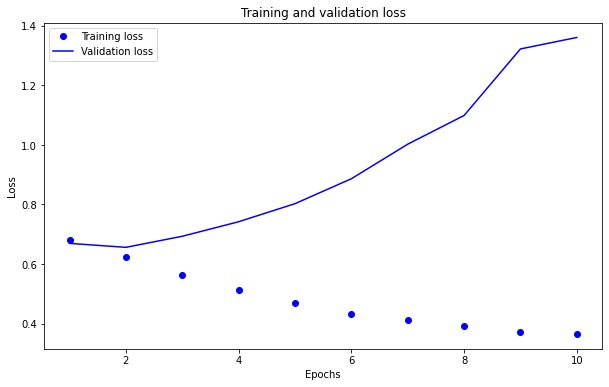

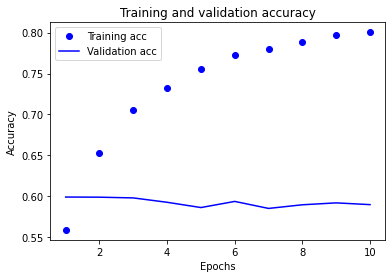

In [12]:
model_2 = models.Sequential()
model_2.add(layers.Embedding(10000, 128))
# model_2.add(layers.LSTM(128,dropout=0.2,recurrent_dropout=0.2,return_sequences=True))
model_2.add(layers.LSTM(64,dropout=0,recurrent_dropout=0))
model_2.add(layers.Dense(32, activation='relu'))
model_2.add(layers.Dense(32, activation='relu'))
model_2.add(layers.Dense(32, activation='relu'))
model_2.add(layers.Dense(1, activation='sigmoid'))

model_2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Iterate on your training data by calling the fit() method of your model
history = model_2.fit(X_par_train, y_par_train,
                    epochs=10,
                    batch_size=500,
                    validation_data = (X_val,y_val)
                    )

# plot the results of loss values from the training set and validtion set
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.figure(figsize=(10,6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# plot the results of accuracy from the training set and validtion set
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Performance on partial training set

In [14]:
preds_Y_par_train = model_2.predict(X_par_train)
preds_Y_par_train =(preds_Y_par_train>0.5).astype(int)

accuracy = accuracy_score(y_par_train, preds_Y_par_train)
precision = precision_score(y_par_train, preds_Y_par_train,average=None,labels=[0,1]) # average=None: The precision scores for each class are returned
recall = recall_score(y_par_train, preds_Y_par_train,average=None,labels=[0,1])
f1 = f1_score(y_par_train, preds_Y_par_train,average=None,labels=[0,1])
print('accuracy: '+str(accuracy)+'\n')
print('precision: '+str(precision)+'\n')
print('recall: '+str(recall)+'\n')
print('F1 score: '+str(f1)+'\n')

c_matrix = confusion_matrix(y_par_train, preds_Y_par_train,labels=[0,1])
print('Confusion matrix: ')
print(c_matrix)

accuracy: 0.8097191261703076

precision: [0.76043623 0.88921249]

recall: [0.91716028 0.69707763]

F1 score: [0.83147753 0.78150916]

Confusion matrix: 
[[10529   951]
 [ 3317  7633]]


## Performance on testing set

In [15]:
preds_Y_test = model_2.predict(X_test)
preds_Y_test =(preds_Y_test>0.5).astype(int)

accuracy = accuracy_score(y_test, preds_Y_test)
precision = precision_score(y_test, preds_Y_test,average=None,labels=[0,1]) # average=None: The precision scores for each class are returned
recall = recall_score(y_test, preds_Y_test,average=None,labels=[0,1])
f1 = f1_score(y_test, preds_Y_test,average=None,labels=[0,1])
c_matrix = confusion_matrix(y_test, preds_Y_test,labels=[0,1])
print('accuracy: '+str(accuracy)+'\n')
print('precision: '+str(precision)+'\n')
print('recall: '+str(recall)+'\n')
print('F1 score: '+str(f1)+'\n')
print('Confusion matrix: ')
print(c_matrix)

accuracy: 0.596148359486448

precision: [0.58211009 0.61924528]

recall: [0.71553425 0.47386659]

F1 score: [0.64196282 0.5368886 ]

Confusion matrix: 
[[2538 1009]
 [1822 1641]]


# Model 3:

## Performance on partial training set

## Performance on testing set

# Model 4:

## Performance on partial training set

## Performance on testing set

# Model 5:

## Performance on partial training set

## Performance on testing set

# Model 6:

## Performance on partial training set

## Performance on testing set

# Use all data to train our final Month_abnormal_returns_Classifier

## Use Model 2 as our final model

In [17]:
model = models.Sequential()
model.add(layers.Embedding(10000, 128))
model.add(layers.LSTM(64,dropout=0,recurrent_dropout=0))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Iterate on your training data by calling the fit() method of your model
model.fit(x, y,epochs=10,batch_size=500)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/10
35048/35048 [==============================] - 304s 9ms/step - loss: 0.6698 - accuracy: 0.5681
Epoch 2/10
35048/35048 [==============================] - 302s 9ms/step - loss: 0.6133 - accuracy: 0.6530
Epoch 3/10
35048/35048 [==============================] - 304s 9ms/step - loss: 0.5690 - accuracy: 0.6894
Epoch 4/10
35048/35048 [==============================] - 301s 9ms/step - loss: 0.5255 - accuracy: 0.7186
Epoch 5/10
35048/35048 [==============================] - 302s 9ms/step - loss: 0.4863 - accuracy: 0.7439
Epoch 6/10
35048/35048 [==============================] - 303s 9ms/step - loss: 0.4545 - accuracy: 0.7552
Epoch 7/10
35048/35048 [==============================] - 303s 9ms/step - loss: 0.4268 - accuracy: 0.7674
Epoch 8/10
35048/35048 [==============================] - 304s 9ms/step - loss: 0.4093 - accuracy: 0.7753
Epoch 9/10
35048/35048 [==============================] - 305s 9ms/step - loss: 0.3989 - accuracy: 0.7798
Epoch 10/10
35048/35048 [=====================

# Save Big_Event_Classifier

In [0]:
# SAVE MODEL
model.save('gdrive/My Drive/金融科技Final_project/Month_abnormal_returns_Classifier')